Fold accuracy: 0.97
Fold accuracy: 0.97
Fold accuracy: 0.97
Fold accuracy: 0.97
Fold accuracy: 0.97
Cross-validated accuracy: 0.97 ± 0.00


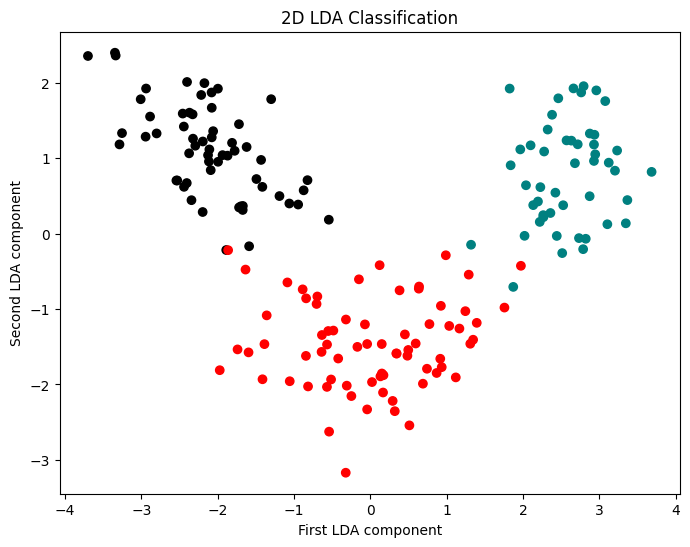

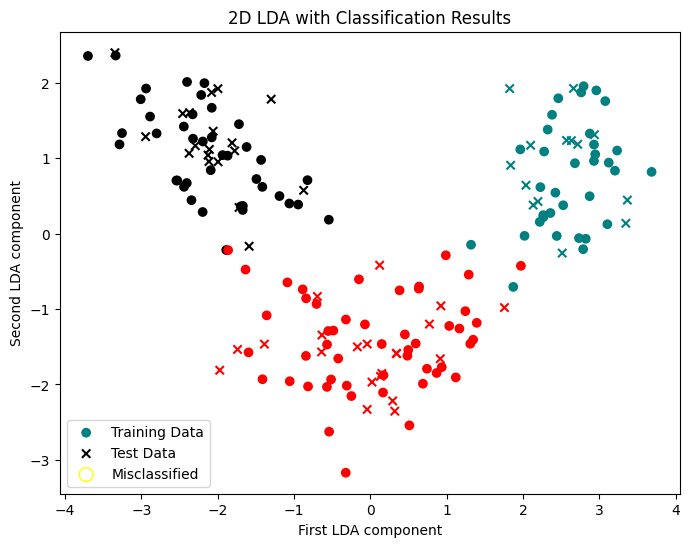

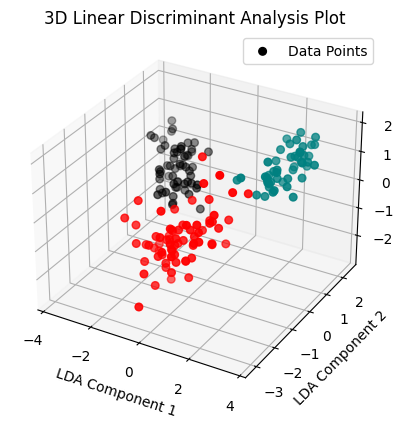

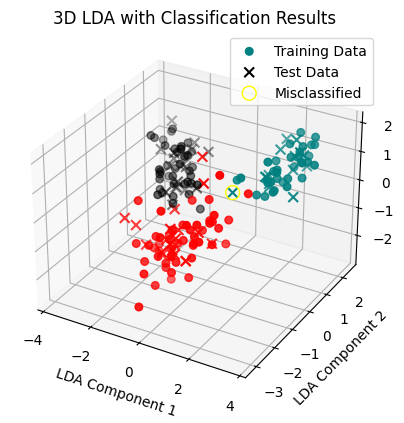

2D LDA Test Accuracy: 1.00
3D LDA Test Accuracy: 0.98


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import KFold, train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
wine = load_wine()
df = pd.DataFrame(wine['data'], columns=wine['feature_names'])
targets = wine['target']

# Standardize the data
def standardize_data(df):
    scaler = (df - df.mean()) / df.std()
    return scaler

scaled_data = standardize_data(df)

# Compute the within-class scatter matrix (Sw)
def compute_within_class_scatter(data, targets):
    n_features = data.shape[1]
    classes = np.unique(targets)
    Sw = np.zeros((n_features, n_features))
    
    for c in classes:
        class_data = data[targets == c]
        mean_class = np.mean(class_data, axis=0)
        scatter_matrix = np.cov(class_data, rowvar=False)
        Sw += scatter_matrix * (class_data.shape[0] - 1)
    
    return Sw

# Compute the between-class scatter matrix (Sb)
def compute_between_class_scatter(data, targets):
    n_features = data.shape[1]
    classes = np.unique(targets)
    mean_overall = np.mean(data, axis=0)
    Sb = np.zeros((n_features, n_features))
    
    for c in classes:
        class_data = data[targets == c]
        mean_class = np.mean(class_data, axis=0)
        n_class = class_data.shape[0]
        mean_diff = (mean_class - mean_overall).reshape(-1, 1)
        Sb += n_class * (mean_diff @ mean_diff.T)
    
    return Sb

# Solve the generalized eigenvalue problem for (Sw^-1 * Sb)
def compute_eigen(Sw, Sb):
    eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(Sw) @ Sb)
    return eigvals, eigvecs

# Sort eigenvalues and eigenvectors
def sort_eigen(eigvals, eigvecs):
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]
    return eigvals, eigvecs

# Project data onto the new space
def project_data(data, eigvecs, n_components):
    return np.dot(data, eigvecs[:, :n_components])

# Nearest Centroid Classifier
def lda_predict(X, W, y_train, X_train):
    X_lda_train = project_data(X_train, W, W.shape[1])
    X_lda_test = project_data(X, W, W.shape[1])
    
    centroids = np.array([np.mean(X_lda_train[y_train == c], axis=0) for c in np.unique(y_train)])
    
    predictions = []
    for sample in X_lda_test:
        distances = np.linalg.norm(centroids - sample, axis=1)
        predictions.append(np.argmin(distances))
    
    return np.array(predictions)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(scaled_data):
    X_train, X_test = scaled_data.iloc[train_index].values, scaled_data.iloc[test_index].values
    y_train, y_test = targets[train_index], targets[test_index]
    
    Sw = compute_within_class_scatter(X_train, y_train)
    Sb = compute_between_class_scatter(X_train, y_train)
    eigvals, eigvecs = compute_eigen(Sw, Sb)
    eigvals, eigvecs = sort_eigen(eigvals, eigvecs)
    
    W = eigvecs[:, :len(np.unique(targets)) - 1]
    y_pred = lda_predict(X_test, W, y_train, X_train)
    
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)
    print(f'Fold accuracy: {accuracy:.2f}')

print(f'Cross-validated accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}')

# Full training on the entire dataset for visualization
Sw = compute_within_class_scatter(scaled_data.values, targets)
Sb = compute_between_class_scatter(scaled_data.values, targets)
eigvals, eigvecs = compute_eigen(Sw, Sb)
eigvals, eigvecs = sort_eigen(eigvals, eigvecs)

# Plot 2D LDA
x_lda = project_data(scaled_data, eigvecs, 2)
plt.figure(figsize=(8, 6))
pc1 = x_lda[:, 0]
pc2 = x_lda[:, 1]
colors = np.array(["black", "red", "teal"])
plt.scatter(pc1, pc2, c=colors[targets])
plt.xlabel('First LDA component')
plt.ylabel('Second LDA component')
plt.title('2D LDA Classification')
plt.show()

# Perform LDA with 2 components for classification results
X_train, X_test, y_train, y_test = train_test_split(scaled_data, targets, test_size=0.3, random_state=42)
W_2d = eigvecs[:, :2]
x_lda_train_2d = project_data(X_train, W_2d, 2)
y_pred_2d = lda_predict(X_test.values, W_2d, y_train, X_train.values)

# Plot 2D LDA with Classification Results
plt.figure(figsize=(8, 6))
plt.scatter(x_lda_train_2d[:, 0], x_lda_train_2d[:, 1], c=colors[y_train], marker='o', label='Training Data')

# Project test data for visualization
x_lda_test_2d = project_data(X_test.values, W_2d, 2)
plt.scatter(x_lda_test_2d[:, 0], x_lda_test_2d[:, 1], c=colors[y_pred_2d], marker='x', label='Test Data')

# Highlight misclassified points
misclassified = (y_pred_2d != y_test)
plt.scatter(x_lda_test_2d[misclassified, 0], x_lda_test_2d[misclassified, 1], facecolors='none', edgecolors='yellow', s=100, label='Misclassified')

plt.xlabel('First LDA component')
plt.ylabel('Second LDA component')
plt.title('2D LDA with Classification Results')
plt.legend()
plt.show()

# Perform LDA with 3 components for visualization
lda_components = project_data(scaled_data, eigvecs, 3)
new_X_lda = pd.DataFrame(data=lda_components, columns=['LD1', 'LD2', 'LD3'])

# Plot 3D LDA
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pc1 = lda_components[:, 0]
pc2 = lda_components[:, 1]
pc3 = lda_components[:, 2]

# Plotting the data points in the new 3D space
ax.scatter(pc1, pc2, pc3, c=colors[targets], marker='o', s=30, label='Data Points')

# Customize the plot with labels and a legend
ax.set_xlabel('LDA Component 1')
ax.set_ylabel('LDA Component 2')
ax.set_zlabel('LDA Component 3')
ax.set_title('3D Linear Discriminant Analysis Plot')
ax.legend()

plt.show()

# Perform LDA with 3 components for classification results
W_3d = eigvecs[:, :3]
x_lda_train_3d = project_data(X_train, W_3d, 3)
y_pred_3d = lda_predict(X_test.values, W_3d, y_train, X_train.values)
x_lda_test_3d = project_data(X_test.values, W_3d, 3)

# Plotting the 3D LDA with Classification Results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the training data points
ax.scatter(x_lda_train_3d[:, 0], x_lda_train_3d[:, 1], x_lda_train_3d[:, 2], c=colors[y_train], marker='o', s=30, label='Training Data')

# Plot the test data points with predicted labels
ax.scatter(x_lda_test_3d[:, 0], x_lda_test_3d[:, 1], x_lda_test_3d[:, 2], c=colors[y_pred_3d], marker='x', s=50, label='Test Data')

# Highlight misclassified points
misclassified = (y_pred_3d != y_test)
ax.scatter(x_lda_test_3d[misclassified, 0], x_lda_test_3d[misclassified, 1], x_lda_test_3d[misclassified, 2], facecolors='none', edgecolors='yellow', s=100, label='Misclassified')

ax.set_xlabel('LDA Component 1')
ax.set_ylabel('LDA Component 2')
ax.set_zlabel('LDA Component 3')
ax.set_title('3D LDA with Classification Results')
ax.legend()

plt.show()

# Print accuracy
accuracy_2d = np.mean(y_pred_2d == y_test)
accuracy_3d = np.mean(y_pred_3d == y_test)
print(f'2D LDA Test Accuracy: {accuracy_2d:.2f}')
print(f'3D LDA Test Accuracy: {accuracy_3d:.2f}')

